<a href="https://colab.research.google.com/github/chissora/Regression_ActualTOW_Prediction/blob/main/Regression_ActualTOW_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project goal:

The goal of the project is to prepare a regression model predicting so called Take-Off Weight of an aircraft.

# Description of Columns in the Dataset:

* DepartureDate – date of departure
* DepartureYear – year of departure
* DepartureMonth – month of departure
* DepartureDay – day of departure
* FlightNumber – flight number
* DepartureAirport – departure airport code
* ArrivalAirport – arrival airport code
* Route – route
* ActualFlightTime – flight time
* ActualTotalFuel – burnt fuel
* ActualTOW – take-off weight (kg)
* FlownPassengers – flown passengers
* BagsCount – flown bags
* FlightBagsWeight – flown bags weight

# Import:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load data:

In [ ]:
training_data = pd.read_csv('/content/training.csv', sep='\t')
validation_data = pd.read_csv('/content/validation.csv', sep='\t')

# Understanding the Data:

In [ ]:
# Display the first few rows of training data
print("Training Data:")
print(training_data.head().to_string()) # to_string makes the data clearer for display

# Display information about training data
print("\nTraining Data Info:")
print(training_data.info())

# Statistical summary of training data
print("\nTraining Data Description:")
print(training_data.describe().to_string())

# Checking for missing values in training data
print('\n', training_data.isna().sum())

Training Data:
  DepartureDate  DepartureYear  DepartureMonth  DepartureDay  FlightNumber DepartureAirport ArrivalAirport    Route  ActualFlightTime  ActualTotalFuel ActualTOW FLownPassengers BagsCount FlightBagsWeight
0    01/10/2016           2016              10             1          1145              MAN            SXF  MAN-SXF                91             3660     64016             175        61              440
1    01/10/2016           2016              10             1          1160              CTA            FCO  CTA-FCO                68             3280     66138             182        27              350
2    01/10/2016           2016              10             1          1183              LGW            SNN  LGW-SNN                64             2720     58447             127    (null)           (null)
3    01/10/2016           2016              10             1          1220              ATH            CHQ  ATH-CHQ                35             1682     60587         

In [ ]:
# Display the first few rows of validation data
print("Validation Data:")
print(validation_data.head().to_string(index=False))

# Display information about validation data
print("\nValidation Data Info:")
print(validation_data.info())

# Statistical summary of validation data
print("\nValidation Data Description:")
print(validation_data.describe().to_string())

# Checking for missing values in validation data
print('\n', validation_data.isna().sum())

Validation Data:
DepartureDate  DepartureYear  DepartureMonth  DepartureDay  FlightNumber DepartureAirport ArrivalAirport   Route  ActualFlightTime  ActualTotalFuel FLownPassengers BagsCount FlightBagsWeight
   01/11/2016           2016              11             1          6003              MRS            BES MRS-BES                84             3630             185        43              560
   01/11/2016           2016              11             1          6004              BES            MRS BES-MRS                86             3690             188    (null)           (null)
   01/11/2016           2016              11             1          6542              MRS            STN MRS-STN               100             4390             168        55              720
   01/11/2016           2016              11             1          6541              STN            MRS STN-MRS               100             4690             185        35              460
   01/11/2016           2016

# Data Cleaning and Preparation:

In [ ]:
# Data Cleaning and Preparation
training_data.replace('(null)', pd.NA, inplace=True)
validation_data.replace('(null)', pd.NA, inplace=True)

for col in ['FLownPassengers', 'BagsCount', 'FlightBagsWeight', 'ActualTOW']:
    training_data[col] = pd.to_numeric(training_data[col])
for col in ['FLownPassengers', 'BagsCount', 'FlightBagsWeight']:
    validation_data[col] = pd.to_numeric(validation_data[col])

training_data['DepartureDate'] = pd.to_datetime(training_data['DepartureDate'], format='%d/%m/%Y')
validation_data['DepartureDate'] = pd.to_datetime(validation_data['DepartureDate'], format='%d/%m/%Y')

imputer = SimpleImputer(strategy='median')
training_data[['FLownPassengers', 'BagsCount', 'FlightBagsWeight']] = imputer.fit_transform(training_data[['FLownPassengers', 'BagsCount', 'FlightBagsWeight']])
validation_data[['FLownPassengers', 'BagsCount', 'FlightBagsWeight']] = imputer.transform(validation_data[['FLownPassengers', 'BagsCount', 'FlightBagsWeight']])

training_data.dropna(subset=['ActualTOW'], inplace=True)

# Visualizing the data:

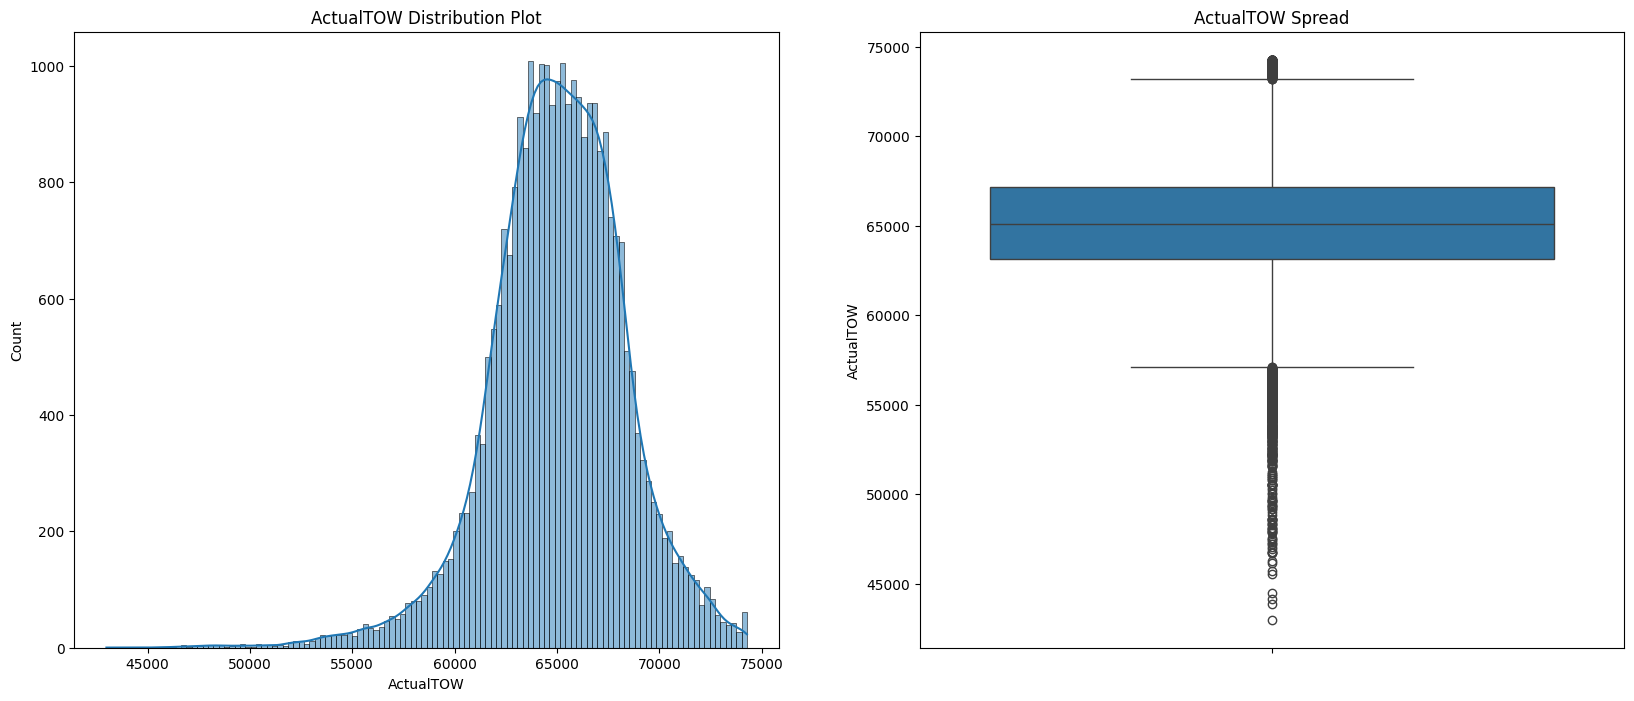

In [ ]:
# Distribution and boxplot for the target variable 'ActualTOW'
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('ActualTOW Distribution Plot')
sns.histplot(training_data['ActualTOW'], kde=True)

plt.subplot(1, 2, 2)
plt.title('ActualTOW Spread')
sns.boxplot(y=training_data['ActualTOW'])

plt.show()


# Feature Extraction and Removal of Unnecessary Columns:

In [ ]:
# Feature extraction from `Timestamp` column
if 'DepartureDate' in training_data.columns:
    training_data['DepartureYear'] = training_data['DepartureDate'].dt.year
    training_data['DepartureMonth'] = training_data['DepartureDate'].dt.month
    training_data['DepartureDay'] = training_data['DepartureDate'].dt.day

if 'DepartureDate' in validation_data.columns:
    validation_data['DepartureYear'] = validation_data['DepartureDate'].dt.year
    validation_data['DepartureMonth'] = validation_data['DepartureDate'].dt.month
    validation_data['DepartureDay'] = validation_data['DepartureDate'].dt.day

# Removing `Timestamp` column if it exists
training_data = training_data.drop(columns=['DepartureDate'], errors='ignore')

# Removing unnecessary columns
training_data = training_data.drop(columns=['Route'])

# Correlation Analysis:

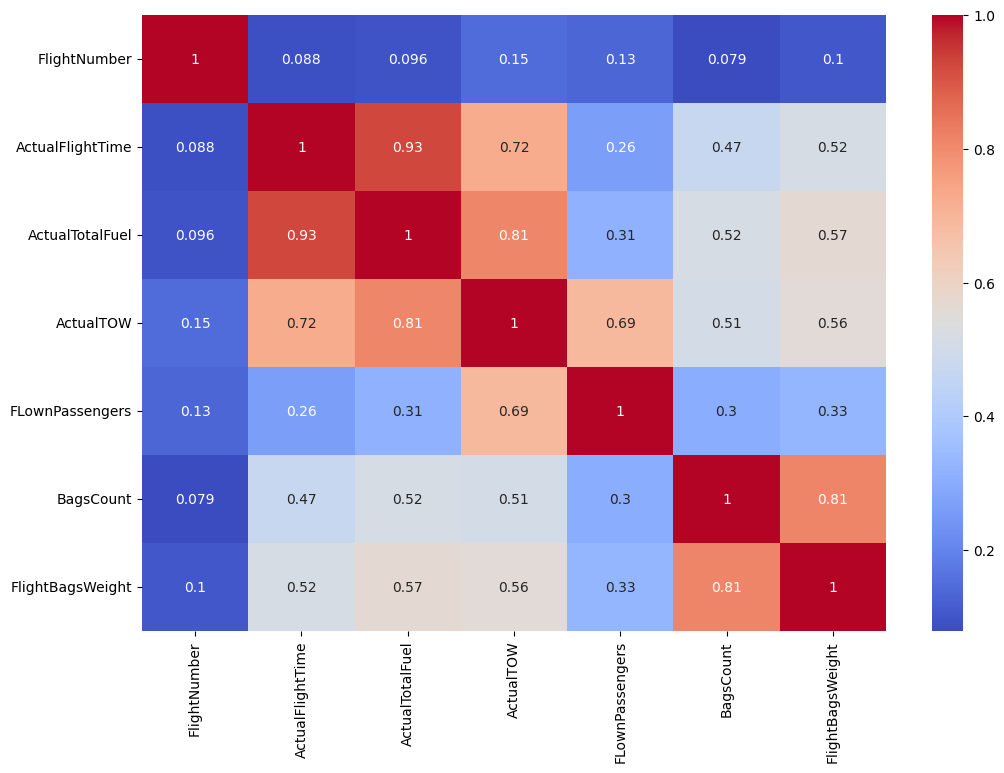

In [ ]:
corr_columns = training_data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = training_data[corr_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Pairplot Analysis:

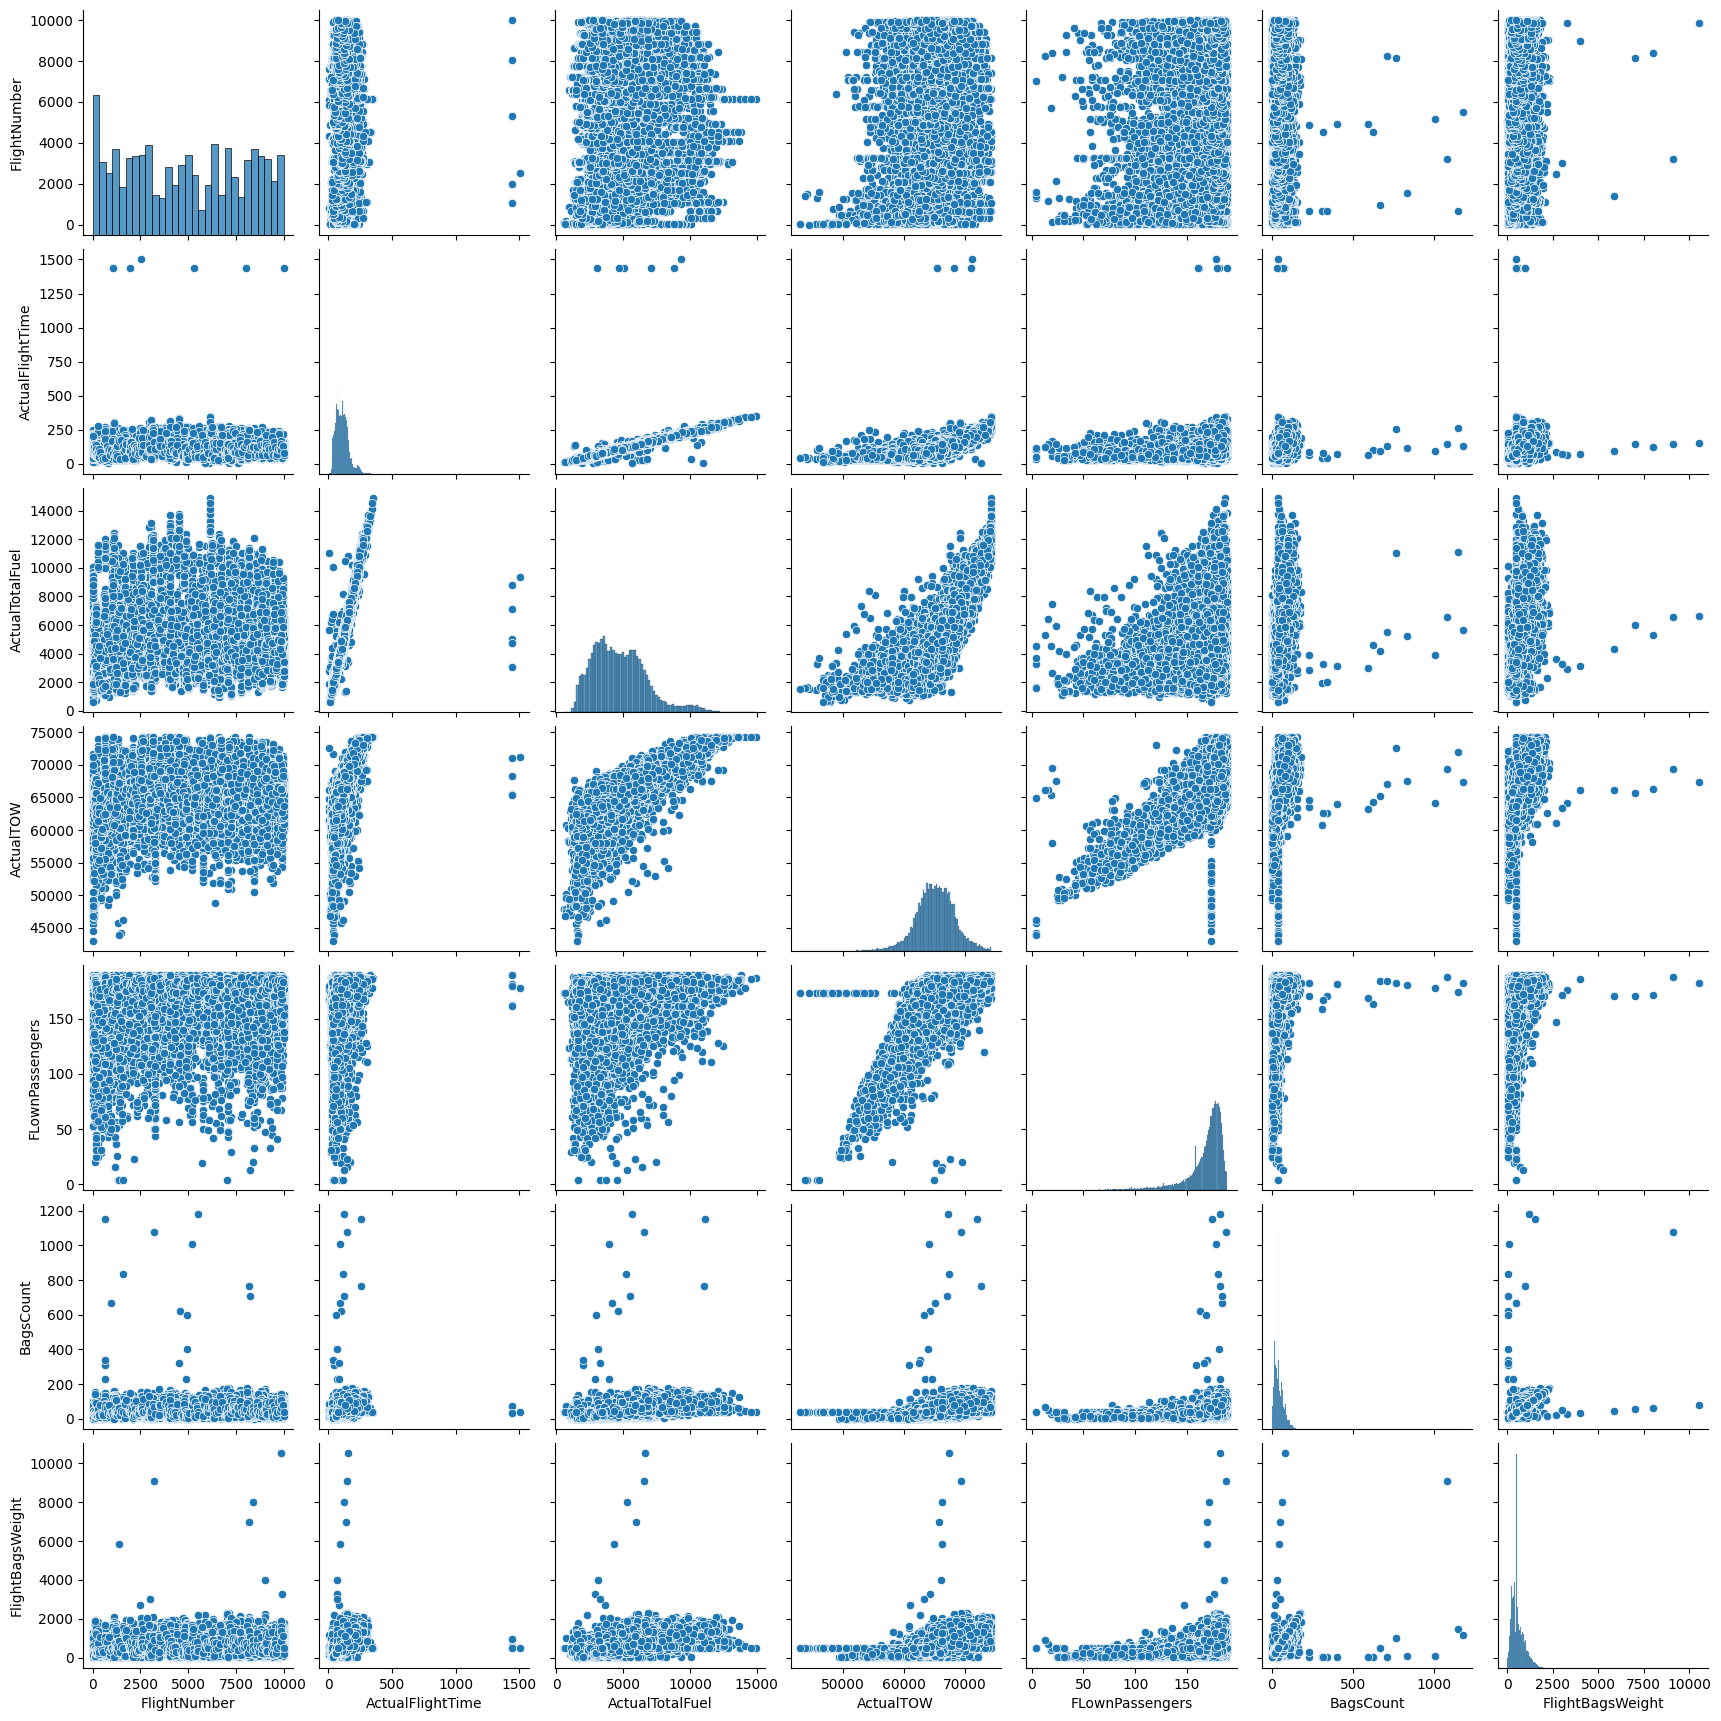

In [ ]:
sns.pairplot(training_data[corr_columns])
plt.show()

# Selecting columns with strong correlation:

In [ ]:
selected_columns = ['ActualFlightTime', 'ActualTotalFuel', 'FLownPassengers', 'BagsCount', 'FlightBagsWeight']

# Preparing data
X = training_data[selected_columns]
y = training_data['ActualTOW']

# Checking data types
print(X.dtypes)

ActualFlightTime      int64
ActualTotalFuel       int64
FLownPassengers     float64
BagsCount           float64
FlightBagsWeight    float64
dtype: object


# Splitting data into training and test sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building a linear regression model:

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating error metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE) before filtering: {mse}')
print(f'Root Mean Squared Error (RMSE) before filtering: {rmse}')
print(f'R-squared (R²) before filtering: {r2}')

Mean Squared Error (MSE) before filtering: 1277473.3055156737
Root Mean Squared Error (RMSE) before filtering: 1130.2536465394278
R-squared (R²) before filtering: 0.8834916838309284


# Visualization of Errors (Before Filtering Outliers):

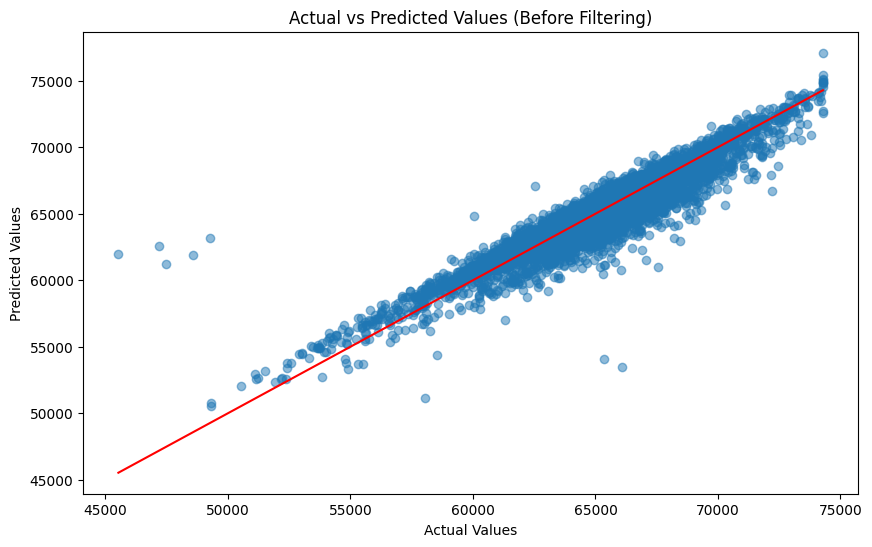

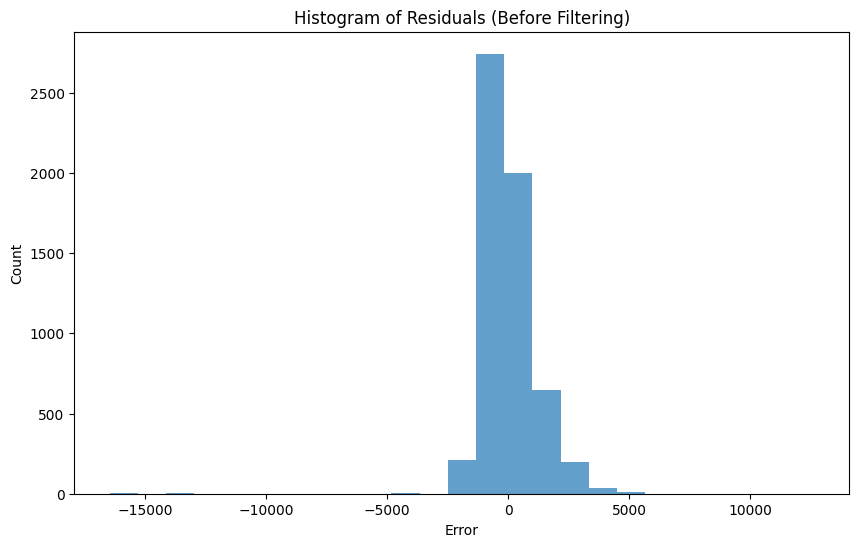

In [ ]:
# Scatter plot of actual vs. predicted values before filtering outliers
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Before Filtering)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Ideal line
plt.show()

# Histogram of residuals (errors) before filtering
errors_before = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors_before, bins=25, alpha=0.7)
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Histogram of Residuals (Before Filtering)')
plt.show()

# Filtering Outliers:

In [ ]:
# Predicting on the training set
y_pred_train = model.predict(X_train)

# Calculating residuals (errors)
errors = y_train - y_pred_train

# Filtering outliers based on percentiles 2.5 and 97.5
lower_bound = np.percentile(errors, 2.5)
upper_bound = np.percentile(errors, 97.5)

# Masks for filtering outliers
mask = (errors >= lower_bound) & (errors <= upper_bound)

# Filtering the dataset based on the mask
X_filtered = X_train[mask]
y_filtered = y_train[mask]

# Checking the shape of the filtered data
print("Shape before filtering:", X_train.shape)
print("Shape after filtering:", X_filtered.shape)

Shape before filtering: (23438, 5)
Shape after filtering: (22266, 5)


# Splitting the filtered data:

In [ ]:
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Building a linear regression model on the filtered data:

In [ ]:
model_filtered = LinearRegression()
model_filtered.fit(X_train_filtered, y_train_filtered)

# Predicting on the test set
y_pred_filtered = model_filtered.predict(X_test_filtered)

# Calculating error metrics
mse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered)
rmse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered, squared=False)
r2_filtered = r2_score(y_test_filtered, y_pred_filtered)

print(f'Mean Squared Error (MSE) after filtering: {mse_filtered}')
print(f'Root Mean Squared Error (RMSE) after filtering: {rmse_filtered}')
print(f'R-squared (R²) after filtering: {r2_filtered}')

Mean Squared Error (MSE) after filtering: 601847.2958488615
Root Mean Squared Error (RMSE) after filtering: 775.7881771778051
R-squared (R²) after filtering: 0.942739125185446


# Visualization of Errors (After Filtering Outliers):

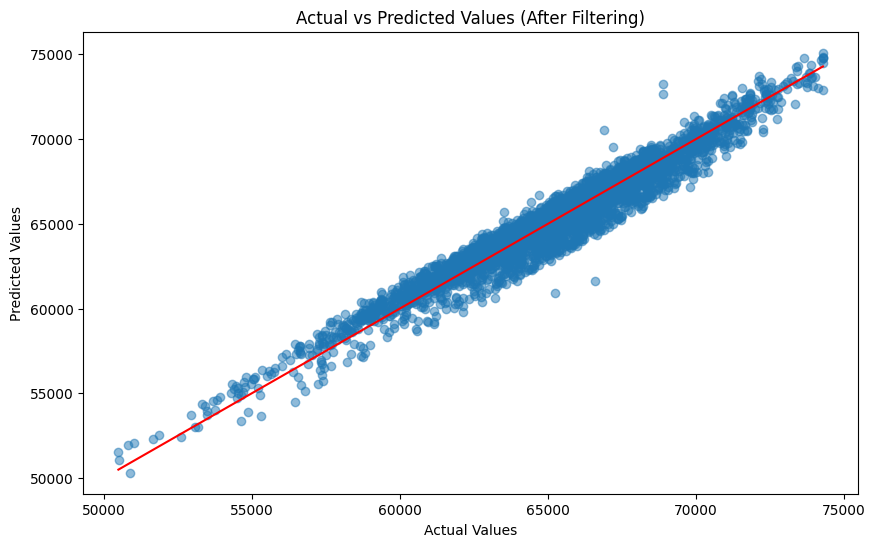

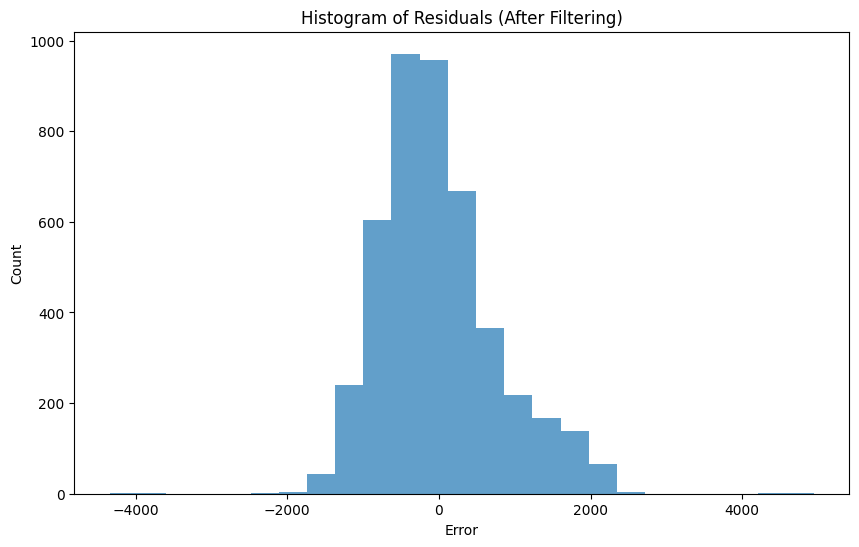

In [ ]:
# Scatter plot of actual vs predicted values after filtering
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (After Filtering)')
plt.plot([min(y_test_filtered), max(y_test_filtered)], [min(y_test_filtered), max(y_test_filtered)], color='red')  # Ideal line
plt.show()

# Histogram of residuals (errors) after filtering
errors_filtered = y_test_filtered - y_pred_filtered
plt.figure(figsize=(10, 6))
plt.hist(errors_filtered, bins=25, alpha=0.7)
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Histogram of Residuals (After Filtering)')
plt.show()

# GridSearchCV for Random Forest:

In [ ]:
# Parameters for GridSearchCV (reduced range)
param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Random Forest model
model_rf = RandomForestRegressor(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f'Best parameters for Random Forest: {best_params}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


# Random Forest with the best parameters:

In [ ]:
# Random Forest model with best parameters
model_rf_best = RandomForestRegressor(**best_params, random_state=42)
model_rf_best.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf = model_rf_best.predict(X_test)

# Calculating error metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Mean Squared Error (MSE) for Random Forest: {mse_rf}')
print(f'Root Mean Squared Error (RMSE) for Random Forest: {rmse_rf}')
print(f'R-squared (R²) for Random Forest: {r2_rf}')

Mean Squared Error (MSE) for Random Forest: 989044.5916586659
Root Mean Squared Error (RMSE) for Random Forest: 994.5072104608723
R-squared (R²) for Random Forest: 0.9097970035908007


# Random Forest model on the filtered data

In [ ]:
# Random Forest model with best parameters
model_rf_best_filtered = RandomForestRegressor(**best_params, random_state=42)
model_rf_best_filtered.fit(X_train_filtered, y_train_filtered)

# Predicting on the test set
y_pred_rf_filtered = model_rf_best_filtered.predict(X_test_filtered)

# Calculating error metrics
mse_rf_filtered = mean_squared_error(y_test_filtered, y_pred_rf_filtered)
rmse_rf_filtered = mean_squared_error(y_test_filtered, y_pred_rf_filtered, squared=False)
r2_rf_filtered = r2_score(y_test_filtered, y_pred_rf_filtered)

print(f'Mean Squared Error (MSE) for Random Forest (filtered): {mse_rf_filtered}')
print(f'Root Mean Squared Error (RMSE) for Random Forest (filtered): {rmse_rf_filtered}')
print(f'R-squared (R²) for Random Forest (filtered): {r2_rf_filtered}')

Mean Squared Error (MSE) for Random Forest (filtered): 611461.6259746552
Root Mean Squared Error (RMSE) for Random Forest (filtered): 781.9601178926296
R-squared (R²) for Random Forest (filtered): 0.941824399876292


# Visualization of Errors (After Filtering Outliers):

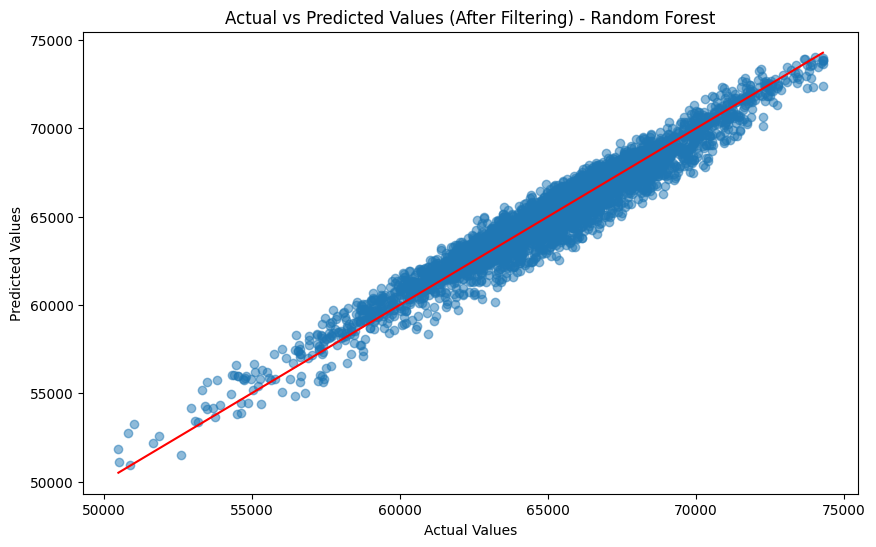

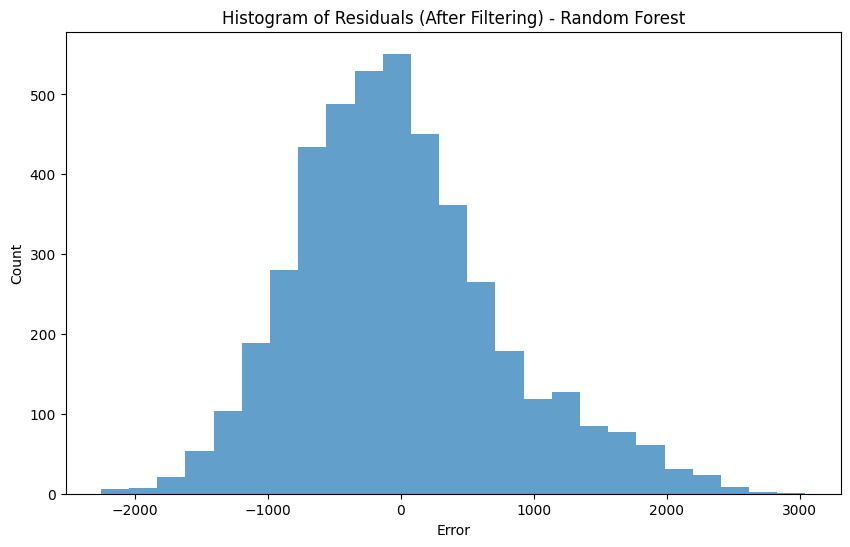

In [ ]:
# Scatter plot of actual vs. predicted values after filtering (Random Forest)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, y_pred_rf_filtered, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (After Filtering) - Random Forest')
plt.plot([min(y_test_filtered), max(y_test_filtered)], [min(y_test_filtered), max(y_test_filtered)], color='red')  # Ideal line
plt.show()

# Histogram of residuals (errors) after filtering (Random Forest)
errors_filtered_rf = y_test_filtered - y_pred_rf_filtered
plt.figure(figsize=(10, 6))
plt.hist(errors_filtered_rf, bins=25, alpha=0.7)
plt.xlabel('Error')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
plt.title('Histogram of Residuals (After Filtering) - Random Forest')
plt.show()

# Building and Evaluating Random Forest Model with Best Parameters:

In [ ]:
# Preparing validation data
X_validation = validation_data[selected_columns]

# Predicting on validation data using the best model (filtered linear regression)
y_validation_pred_lr_filtered = model_filtered.predict(X_validation)

# Converting predicted values to int
y_validation_pred_lr_filtered = y_validation_pred_lr_filtered.astype(int)

# Adding predicted values to validation dataset
validation_data['Predicted_ActualTOW'] = y_validation_pred_lr_filtered

# Displaying the first few rows of validation data with the added column
print(validation_data.head().to_string())

# Saving the validation dataset with predicted values to a CSV file
validation_data.to_csv('/content/validation_with_predictions.csv', index=False)

  DepartureDate  DepartureYear  DepartureMonth  DepartureDay  FlightNumber DepartureAirport ArrivalAirport    Route  ActualFlightTime  ActualTotalFuel  FLownPassengers  BagsCount  FlightBagsWeight  Predicted_ActualTOW
0    2016-11-01           2016              11             1          6003              MRS            BES  MRS-BES                84             3630            185.0       43.0             560.0                65142
1    2016-11-01           2016              11             1          6004              BES            MRS  BES-MRS                86             3690            188.0       39.0             490.0                65379
2    2016-11-01           2016              11             1          6542              MRS            STN  MRS-STN               100             4390            168.0       55.0             720.0                64762
3    2016-11-01           2016              11             1          6541              STN            MRS  STN-MRS             

# Conclusions:

* Linear Regression Model:
    Filtering outliers significantly improved the performance of the linear regression model. The RMSE decreased from 1,130.25 to 775.79, indicating a better fit to the data.

* Random Forest Model:
    The Random Forest model performed better than the linear regression model before filtering outliers. The RMSE for the Random Forest model was 994.51. On the filtered data, the Random Forest model achieved the following results RMSE 781.96

* Best Model:
    The best model was the linear regression model after filtering outliers, with an RMSE of 775.79. This model was used to predict the Take-Off Weight on the validation data.